IMPORTING ALL NECESSARY LIBRARIES AND MODULES

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


IMPORTING OR READING THE FILE

In [5]:
df = pd.read_csv("data.csv", encoding="latin1")
print("Shape:", df.shape)
df.head()


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


CLEANING THE DATA

In [6]:
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.drop_duplicates()
print(df.shape)
df.head()

(392692, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


CREATING A TOTAL PRICE COLUMN

In [7]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df[["CustomerID", "Quantity", "UnitPrice", "TotalPrice"]].head()

,CustomerID,Quantity,UnitPrice,TotalPrice
0,17850.0,6,2.55,15.30
1,17850.0,6,3.39,20.34
2,17850.0,8,2.75,22.00
3,17850.0,6,3.39,20.34
4,17850.0,6,3.39,20.34


NOW THIS IS THE MOST CRUCIAL STEP OF CUSTOMER SEGMENTATION AS IN THIS WE ARE CREATING A RFM TABLE WHICH SHOWS RECENCY , FREQUENCY AND MONETARY OF THE CUSTOMER'S SHOPPING

In [8]:
today_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
RFM = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (today_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()
RFM.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
RFM.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [9]:
RFM.shape

(4338, 4)

SCALING THE DATA SO THAT IT BECOME EASIER FOR THE MODEL TO INTERPRET AND FORM CLUSTERS

In [10]:
scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(RFM[["Recency", "Frequency", "Monetary"]])
RFM_scaled[:5]

array([[ 2.33457414, -0.4250965 ,  8.36301037],
       [-0.90534032,  0.3544168 ,  0.2516989 ],
       [-0.17535959, -0.03533985, -0.02798783],
       [-0.73534481, -0.4250965 , -0.03240559],
       [ 2.17457836, -0.4250965 , -0.19081155]])

FINDING THE NUMBER OF OPTIMAL CLUSTERS FOR THE SEGMENTATION OF DATA POINTS

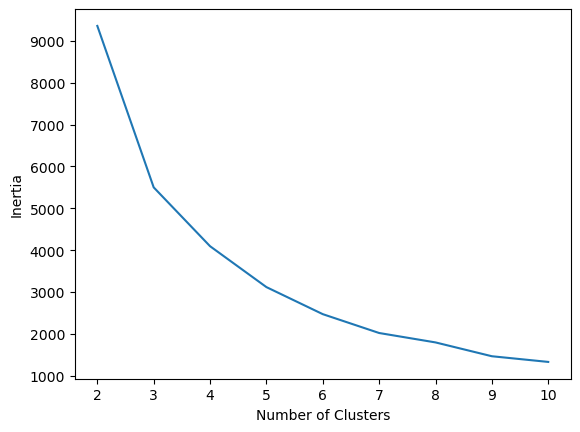

In [11]:
inertia = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(RFM_scaled)
    inertia.append(km.inertia_)
plt.plot(range(2, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


SEGREGATING DATA POINTS INTO 3 CLUSTERS

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
RFM["Cluster"] = kmeans.fit_predict(RFM_scaled)
RFM.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,1
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


In [13]:
RFM.groupby("Cluster").mean()

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15282.157846,40.983906,4.852677,2005.830431
1,15354.225984,246.023788,1.582800,629.357439
2,15310.642857,7.142857,80.214286,122748.792143


CHECKING THE TOTAL NUMBER OF DATA POINTS IN EACH CLUSTER

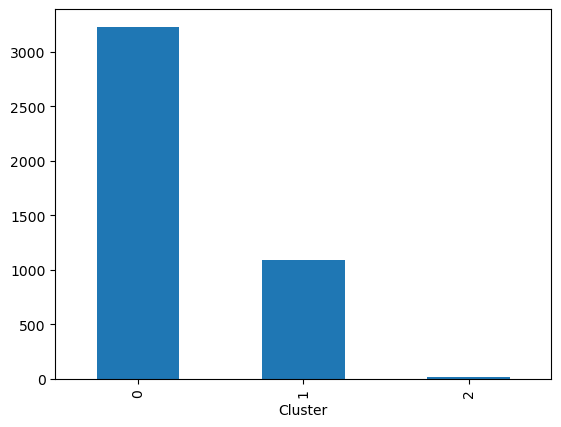

In [14]:
RFM["Cluster"].value_counts().plot(kind="bar")
plt.show()

SEGMENTING THE CUSTOMERS INTO VIP, LOW RISK AND HIGH RISK CLUSTERS

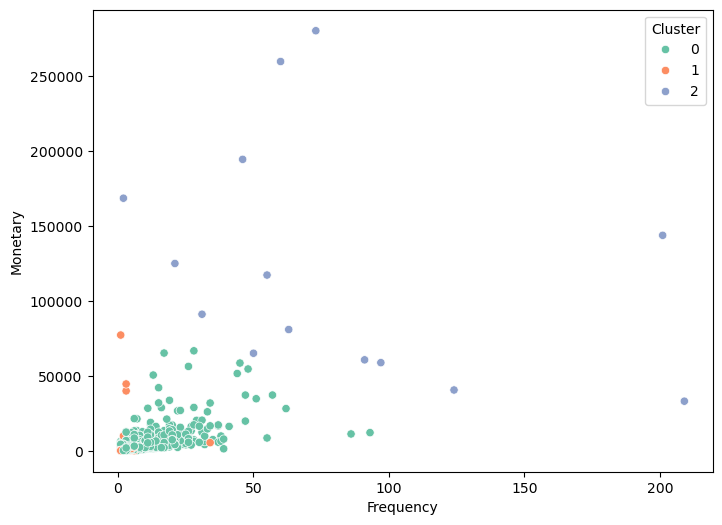

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=RFM,x="Frequency",y="Monetary",hue="Cluster",palette="Set2"
)
plt.show()

CHECKING THE RECENT BUYERS AND THEIER SPENDING BEHAVIOR

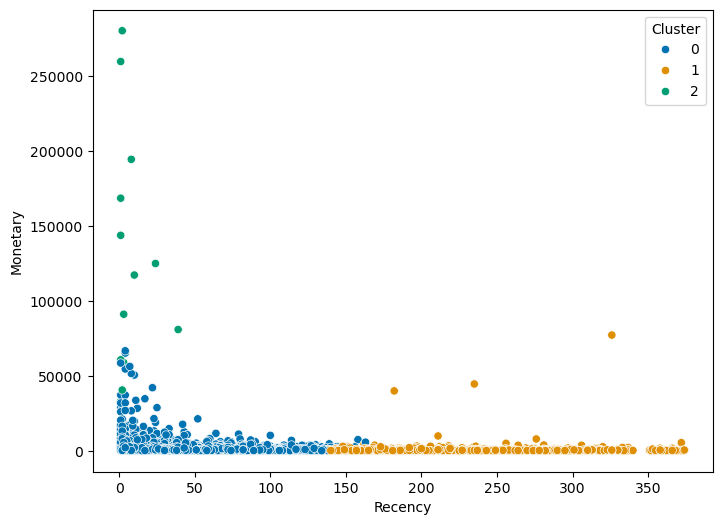

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=RFM,x="Recency",y="Monetary",hue="Cluster",palette="colorblind"
)
plt.show()